### CellAssign
https://docs.scvi-tools.org/en/stable/tutorials/notebooks/scrna/cellassign_tutorial.html#create-and-fit-cellassign-model

In [1]:
import scanpy as sc
import anndata as ad
import scvi
import seaborn as sns
import torch
import pandas as pd
from scvi.external import CellAssign
import numpy as np

In [2]:
import os
os.chdir("/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc")
os.getcwd()

'/dcs04/lieber/lcolladotor/spatialHPC_LIBD4035/spatial_hpc'

In [13]:
adata_annot = ad.read_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict.h5")

The initial run used markers from human HPC snRNAseq (one of the references from the manuscript). <br>
Erik will be compiling a list of cell type markers in the next week that will replace the list used in this example.

In [5]:
celltype_markers = pd.read_csv("snRNAseq_hpc/python_analysis/processed-data/Ayhan_2021_TableS2_binary.csv", index_col=0)

In [16]:
key = celltype_markers.index[celltype_markers.index.isin(adata_annot.var_names)]
celltype_markers = celltype_markers.loc[key]
adata_annot = adata_annot[:,key].copy()

In [19]:
lib_size = adata_annot.X.sum(1)
adata_annot.obs["size_factor"] = lib_size / np.mean(lib_size)

In [20]:
scvi.external.CellAssign.setup_anndata(adata_annot, size_factor_key="size_factor")

In [22]:
annot_model = CellAssign(adata_annot, celltype_markers)
annot_model.train(early_stopping=True)
#early stopping defaults to patience of 45
#based on the elbow plot from the tutorial that should be good to cutoff well before 400
#https://docs.scvi-tools.org/en/stable/api/reference/scvi.model.SCVI.html#scvi.model.SCVI.train
#https://docs.scvi-tools.org/en/stable/api/reference/scvi.train.Trainer.html#scvi.train.Trainer

/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/jthompso/.conda/envs/snPy/lib/python3.10/site ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/users/jthompso/.conda/envs/snPy/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /users/jthompso/.conda/envs/snPy/lib/python3.10/site ...


Epoch 275/400:  69%|███████████████████████████▌            | 275/400 [1:50:47<50:21, 24.17s/it, v_num=1, train_loss_step=165, train_loss_epoch=170]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 169.132. Signaling Trainer to stop.


In [23]:
annot_model.save("snRNAseq_hpc/python_analysis/processed-data/scvi-CellAssign_model_strict-Ayhan", overwrite=True)

<Axes: xlabel='epoch'>

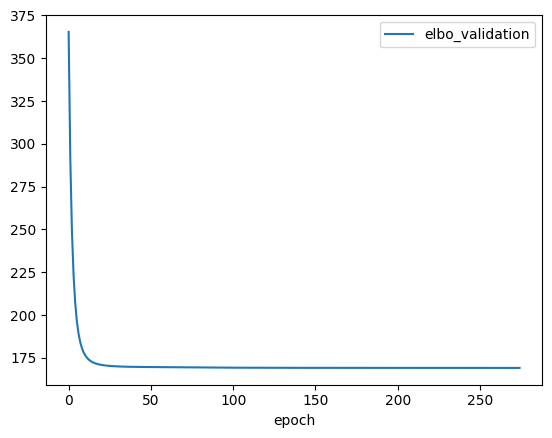

In [24]:
annot_model.history["elbo_validation"].plot()

In [25]:
predictions = annot_model.predict()
predictions.head()

,Astro,GC,Endo,GABA,Micro,OPC,Olig,Pyr
0,2.925622e-16,1.267732e-16,8.626171e-19,3.981786e-17,1.162371e-17,1.691690e-19,1.000000e+00,2.402786e-27
1,4.435993e-07,1.368176e-08,1.559391e-09,6.035303e-10,4.725982e-11,2.728820e-12,9.999995e-01,1.660855e-17
2,1.201596e-18,6.987209e-18,3.964750e-17,1.698626e-19,4.685611e-20,5.284153e-19,1.000000e+00,3.545659e-28
3,5.408753e-03,9.884134e-01,1.468055e-05,8.166699e-04,6.393375e-04,9.329534e-07,4.706255e-03,1.337136e-09
4,9.118209e-67,3.192437e-66,4.531425e-67,8.707129e-67,1.000000e+00,7.760627e-67,1.213542e-68,2.162060e-79


In [4]:
adata = ad.read_h5ad("snRNAseq_hpc/python_analysis/processed-data/adata_qc-strict_scvi-2k-hdg.h5")

In [26]:
adata.obs.index.identical(adata_annot.obs.index)

True

In [31]:
predictions.max(axis=1)

0        1.000000
1        1.000000
2        1.000000
3        0.988413
4        1.000000
           ...   
82480    1.000000
82481    1.000000
82482    1.000000
82483    0.552819
82484    1.000000
Length: 82485, dtype: float64

In [27]:
adata.obs["cellassign_predictions"] = predictions.idxmax(axis=1).values

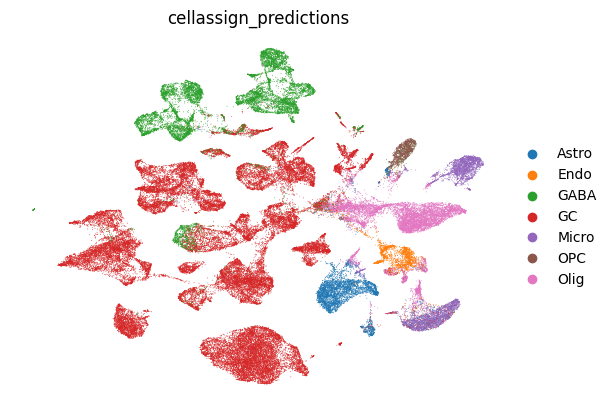

In [28]:
sc.pl.umap(adata, color=["cellassign_predictions"], frameon=False)